# Analyzing the Shopify Global Catalogue Dataset

Below are all the dependencies we need.

In [1]:
from datasets import load_dataset
from collections import Counter
from matplotlib import pyplot as plt
from io import BytesIO
import base64
import pprint
from mlperf_inference_multimodal_vl2l.task import ShopifyGlobalCatalogue
from openai import OpenAI
import numpy as np

/home/shangw/miniconda3/envs/mlperf-inf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the dataset from HuggingFace.

In [ ]:
dataset = load_dataset("Shopify/the-catalogue-public-beta", token="...")
print(dataset)

Generating test split: 100%|██████████| 9730/9730 [00:00<00:00, 14566.39 examples/s]

DatasetDict({
    train: Dataset({
        features: ['product_title', 'product_description', 'product_image', 'potential_product_categories', 'ground_truth_brand', 'ground_truth_is_secondhand', 'ground_truth_category'],
        num_rows: 38917
    })
    test: Dataset({
        features: ['product_title', 'product_description', 'product_image', 'potential_product_categories', 'ground_truth_brand', 'ground_truth_is_secondhand', 'ground_truth_category'],
        num_rows: 9730
    })
})


Choose a dataset split.

In [3]:
split = "train"

Display a sample from the dataset, and how that sample would be formulated into a prompt:

An example product at the index 456 of the train split:
product_title: Airthereal Whole House Water Filter Housing, Sediment Filters for Well and City Water, 20"x4.5" Sediment Whole House Water Filter Cartridges, Pre-Filtration System for Home, includes1-Pack CTO Filter
product_description: About This Premium Construction: Crafted with premium quality to meet NSF standards, reinforced polypropylene housing ensures strength and chemical resistance to provide you with safe and healthy filtered water. Transparent Monitoring: The transparent housing allows full visibility of the filter's status so you know when it needs to be cleaned or replaced. This feature enhances user convenience and ensures timely maintenance. Enhanced Leak Protection: Our 20" x 4.5" filter housing boasts an upgraded design with thickened ports made of brass and a double O-ring system. This ensures a secure and leak-free performance, addressing concerns about water leakage reported in other similar inline filter hous

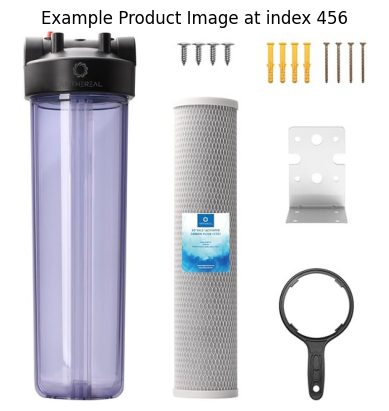

In [8]:
sample_index = 456
print(f"An example product at the index {sample_index} of the {split} split:")
for key, value in dataset[split][sample_index].items():
    print(f"==========\n{key}: {value}")
    if isinstance(value, list):
        print(f"{len(value)=}")
plt.imshow(dataset[split][sample_index]["product_image"])
plt.axis('off')
plt.title(f"Example Product Image at index {sample_index}")
plt.show()

Most samples have 8 or 9 potential product categories:

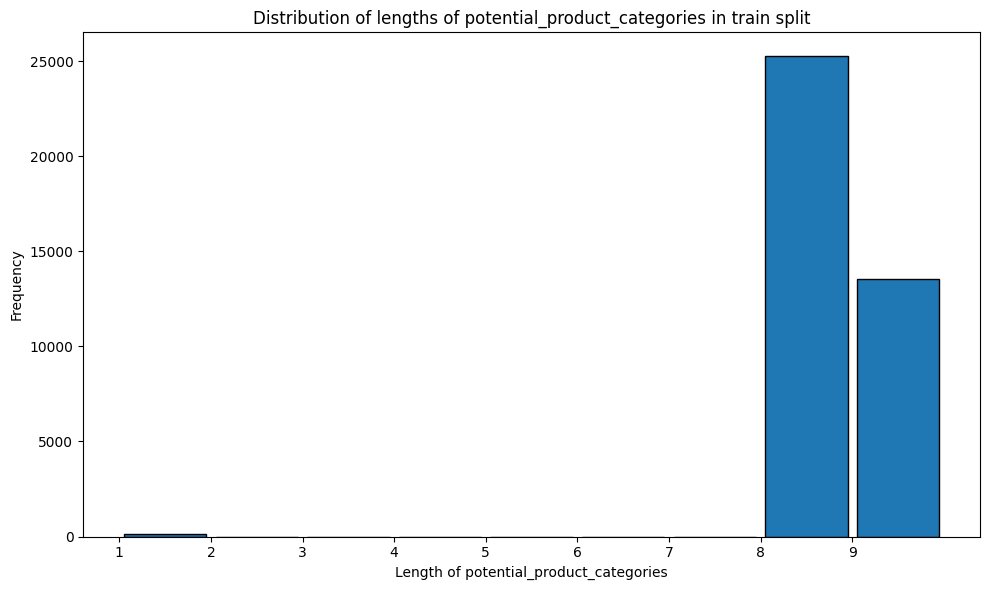

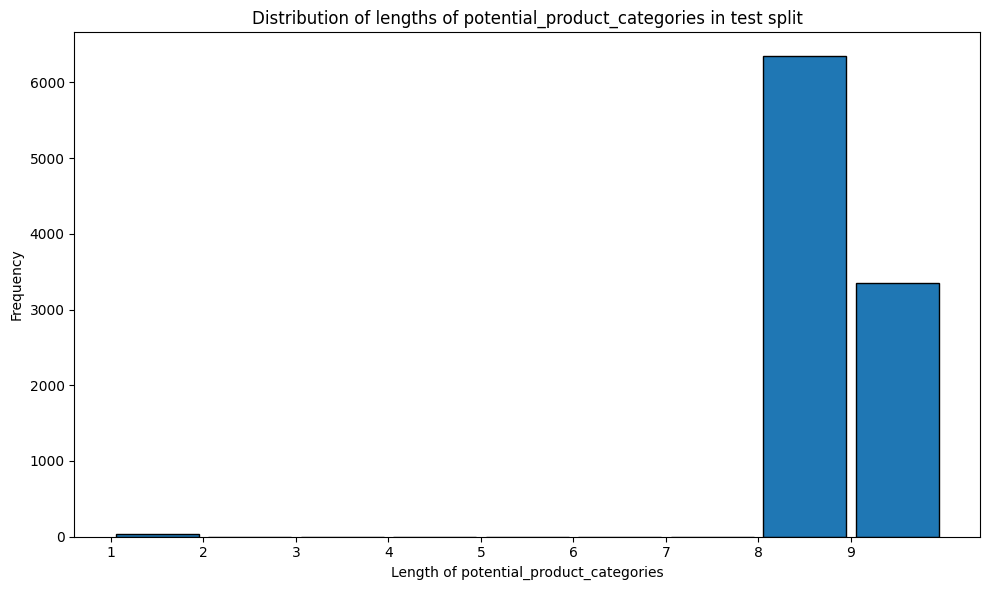

In [5]:
# Plot histogram of the length of potential_product_categories in the split split
def plot_len_potential_product_categories(dataset, split):
    lengths = [len(product.get("potential_product_categories", [])) for product in dataset[split]]

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=range(min(lengths), max(lengths) + 2), edgecolor='black', rwidth=0.9)
    plt.xlabel('Length of potential_product_categories')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of lengths of potential_product_categories in {split} split')
    plt.xticks(range(min(lengths), max(lengths) + 1))
    plt.tight_layout()
    plt.show()

plot_len_potential_product_categories(dataset, "train")
plot_len_potential_product_categories(dataset, "test")

The correct categories are often the first catagery or the last category in the list of candidates:

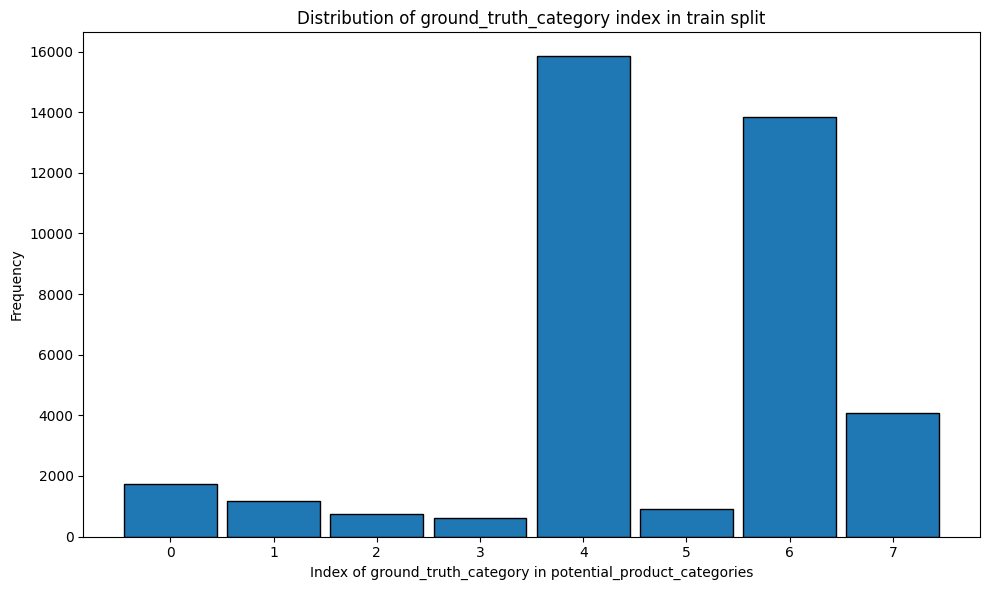

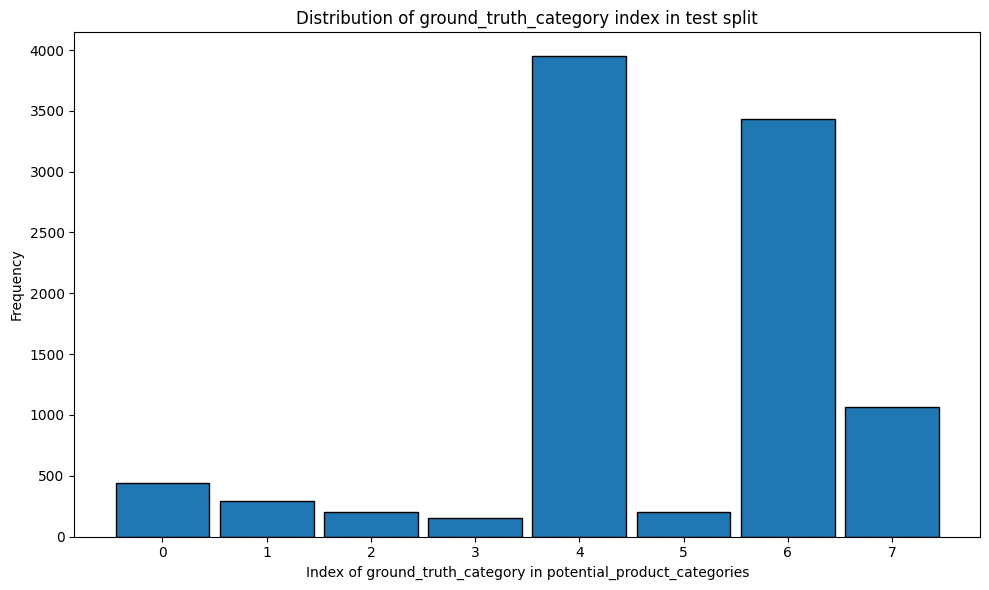

In [6]:
def plot_indices_ground_truth_category_in_potential_product_categories(dataset, split):
    # Plot histogram of positions/indices of ground_truth_category in potential_product_categories

    # Collect the indices
    position_indices = []
    for product in dataset[split]:
        gt = product.get("ground_truth_category")
        pot = product.get("potential_product_categories", [])
        idx = pot.index(gt)
        position_indices.append(idx)

    # Plot the histogram
    plt.figure(figsize=(10,6))
    plt.hist(position_indices, bins=np.arange(-0.5, max(position_indices)+1.5, 1), edgecolor='black', rwidth=0.9)
    plt.xlabel("Index of ground_truth_category in potential_product_categories")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of ground_truth_category index in {split} split")
    plt.xticks(range(min(position_indices), max(position_indices)+1))
    plt.tight_layout()
    plt.show()

plot_indices_ground_truth_category_in_potential_product_categories(dataset, "train")
plot_indices_ground_truth_category_in_potential_product_categories(dataset, "test")

Check if there are duplicate samples:

In [17]:
# Check for duplicates in the concatenated train+test splits

# First, concatenate the splits
all_samples = list(dataset["train"]) + list(dataset["test"])

# Define a function for getting a unique 'signature' of a product
# Let's assume the full product dict is used, serialized to a string
import json

def sample_signature(product):
    # Convert the image to bytes
    image_file = BytesIO()
    product["product_image"].save(image_file, format="JPEG")
    image_bytes = image_file.getvalue()
    # Base64 encode the bytes
    encoded_image = base64.b64encode(image_bytes).decode('utf-8')
    product["product_image"] = encoded_image
    # Dump to canonical string form (sorted keys) to ensure stable comparison
    return json.dumps(product, sort_keys=True, ensure_ascii=False)

# Build signatures and count
signatures = [sample_signature(prod) for prod in all_samples]
num_total = len(signatures)
num_unique = len(set(signatures))

print(f"Total samples in train+test: {num_total}")
print(f"Unique samples in train+test: {num_unique}")
if num_total > num_unique:
    print(f"Number of duplicates: {num_total - num_unique} ({num_total - num_unique} duplicates found)")
    # Optionally, show which duplicates exist (indices, or the signature itself)
    from collections import Counter
    sig_counts = Counter(signatures)
    dup_sigs = [sig for sig, count in sig_counts.items() if count > 1]
    print(f"Example duplicate sample(s):")
    for i, sig in enumerate(dup_sigs[:3]):  # Show at most 3 duplicate types
        print(f"Duplicate {i+1}:")
        # Print the sample in readable format
        pprint.pprint(json.loads(sig))
        print("-" * 40)
else:
    print("No duplicate samples found in concatenated train+test splits.")



Total samples in train+test: 48597
Unique samples in train+test: 48597
No duplicate samples found in concatenated train+test splits.


This is how that sample will be formulated into a prompt:

In [ ]:
messages = ShopifyGlobalCatalogue.formulate_messages(dataset[sample_index])
print("Example prompt (messages):")
pprint.pprint(messages)

In [12]:
import random
import pympler.asizeof as asizeof

def estimate_max_num_samples_to_load_into_host_memory(dataset, split):
    num_estimation_samples = 200
    allowed_memory_footprint = 1024 * 1024 * 1024  # 1GB
    estimation_indices = random.sample(
        range(len(dataset[split])),
        k=num_estimation_samples,
    )
    estimation_samples = [
        ShopifyGlobalCatalogue.formulate_messages(dataset[split][i]) for i in estimation_indices
    ]
    avg_messages_footprint = sum(
        asizeof.asizeof(m) for m in estimation_samples
    ) / len(estimation_samples)
    result = min(
        round(allowed_memory_footprint / avg_messages_footprint),
        len(dataset[split]),
    )
    print(f"Estimated maximum number of samples to load into the host memory is {result}.")

estimate_max_num_samples_to_load_into_host_memory(dataset, "train")
estimate_max_num_samples_to_load_into_host_memory(dataset, "test")


Estimated maximum number of samples to load into the host memory is 4878.
Estimated maximum number of samples to load into the host memory is 4965.


We wanna take a look into the distribution of the various fields.

In [7]:

def count_and_plot_top_n(dataset, split, value_fn, field_label, n=10):
    """
    Counts occurrences using a custom value extraction function.

    Args:
        dataset: The HuggingFace dataset as returned by load_dataset.
        split: The split of the dataset to use.
        value_fn: A function (product_dict) -> value, to extract the field to be counted.
        field_label: String label to describe the field when printing (default: function name or 'field').
        n: Number of top frequent items to print.
    """
    values = [value_fn(product) for product in dataset[split]]
    # Remove Nones (missing values)
    values = [v for v in values if v is not None]
    counts = Counter(values)
    top_n = counts.most_common(n)
    import matplotlib.pyplot as plt

    # Use only the top n keys and their counts for the histogram
    keys = [key for key, _ in top_n]
    values = [count for _, count in top_n]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(keys)), values, tick_label=[str(k) for k in keys])
    plt.title(f"Top {n} {field_label} in the {split} split")
    plt.xlabel(f"{field_label.title()}")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    assert counts.total() == len(dataset[split]), f"Counts total {counts.total()} does not match dataset length {len(dataset[split])}"

Top 50 categories are:

/tmp/ipykernel_1494607/887610762.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


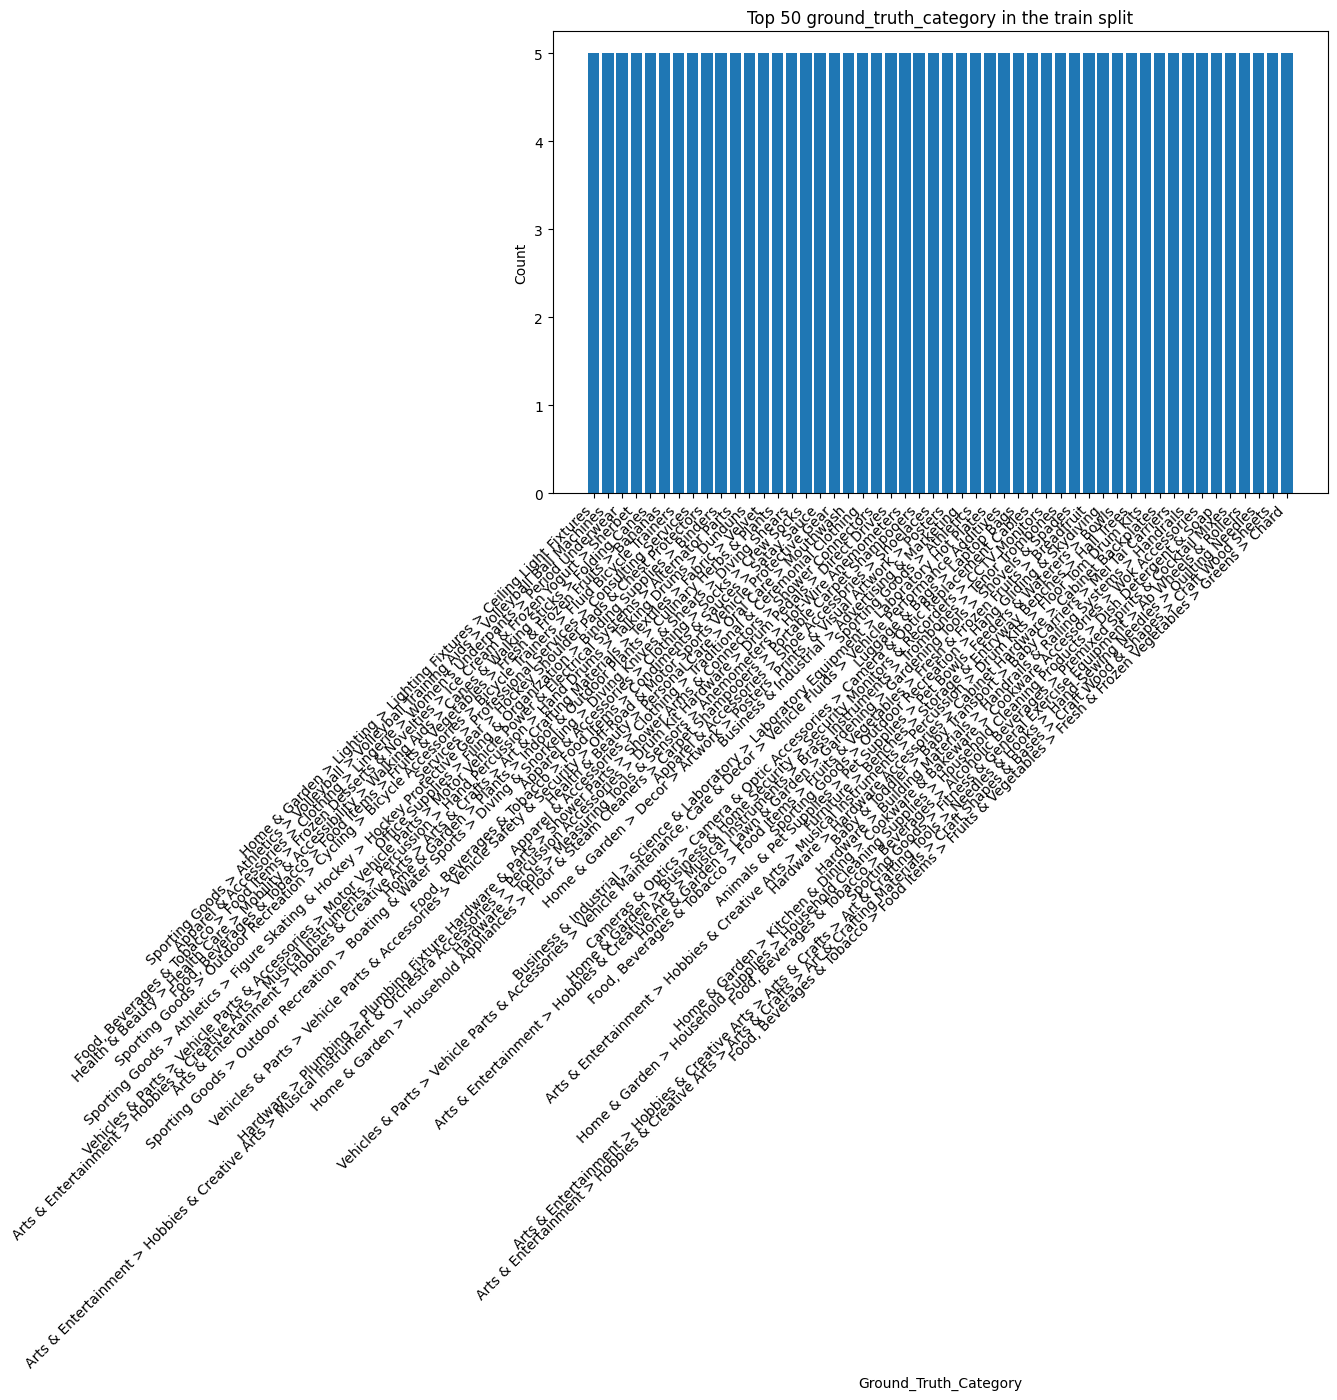

/tmp/ipykernel_1494607/887610762.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


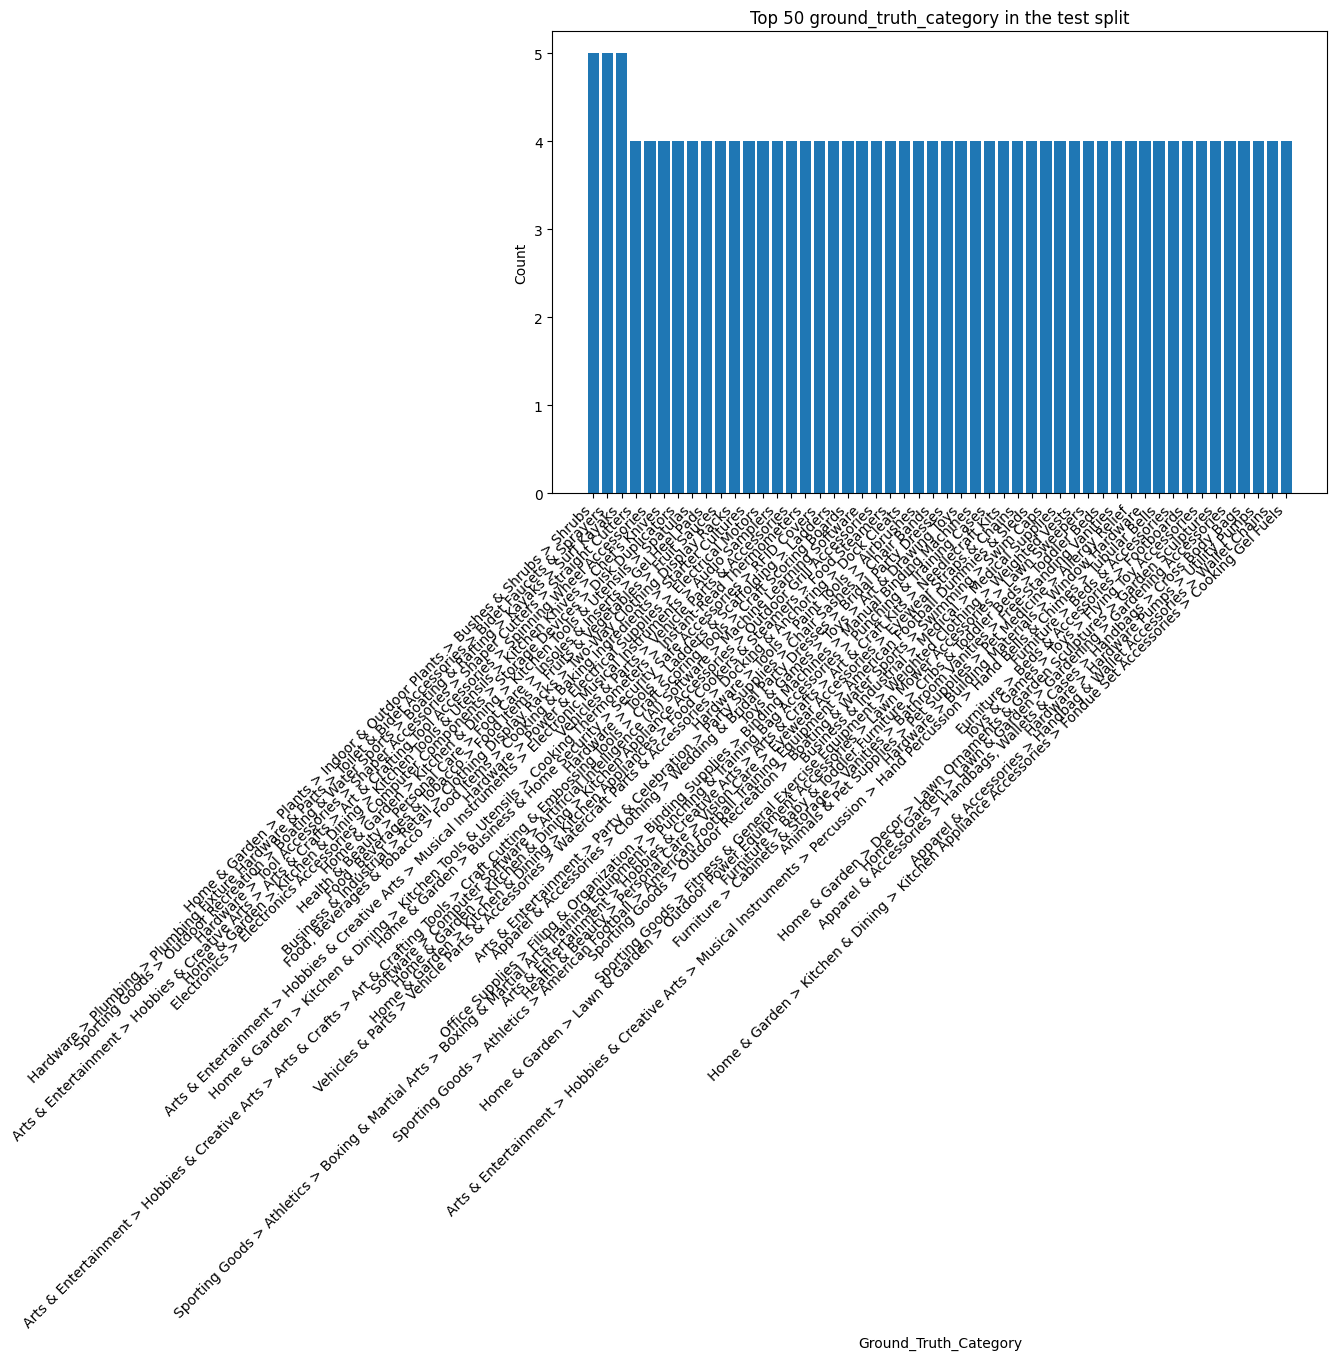

In [9]:
count_and_plot_top_n(dataset, "train", lambda p: p.get('ground_truth_category'), field_label='ground_truth_category', n=50)
count_and_plot_top_n(dataset, "test", lambda p: p.get('ground_truth_category'), field_label='ground_truth_category', n=50)

There seems to be a lot of unique categories. The VLM doesn't know a priori the entire list of categories to choose from.

Potential solutions are:
1. Passing the entire list of categories as part of the system prompt to the VLM. 
   However, this would make the system prompt too long.
2. From K: Do some sort of semantic similarity search and return a list of 20 or so 
   categories and then ask the VLM to pick one. Shopify already plan on doing this,
   since it would decouple the model from changes to the taxonomy.

Top 50 brands are:

In [ ]:
count_and_plot_top_n(dataset, lambda p: p.get('brands'), field_label='brands', n=50)

Brands seem to have a similar issue as the categories. There seems to be a lot of unique brands.

The distribution of secondhand vs. new products are:

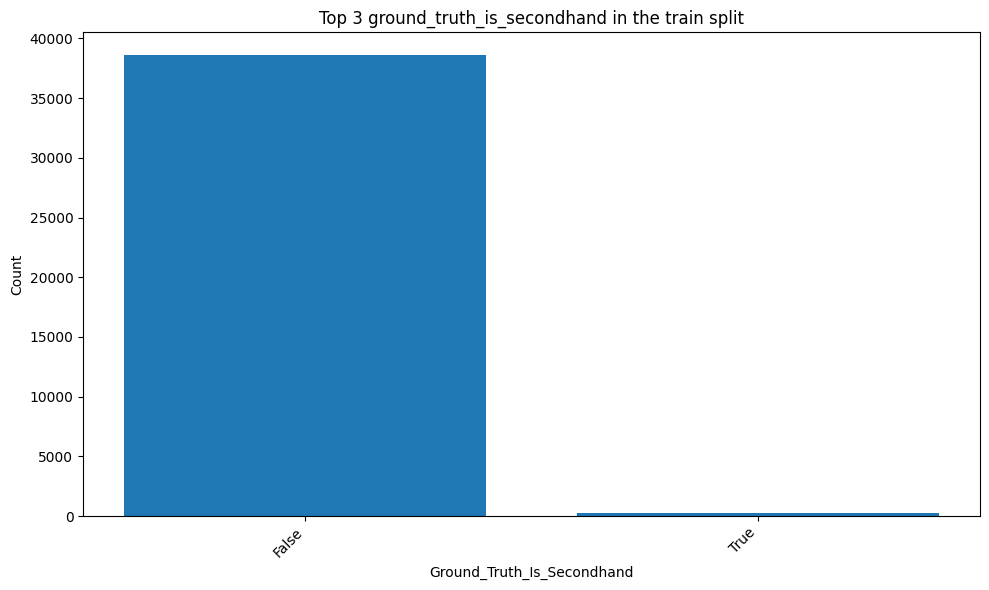

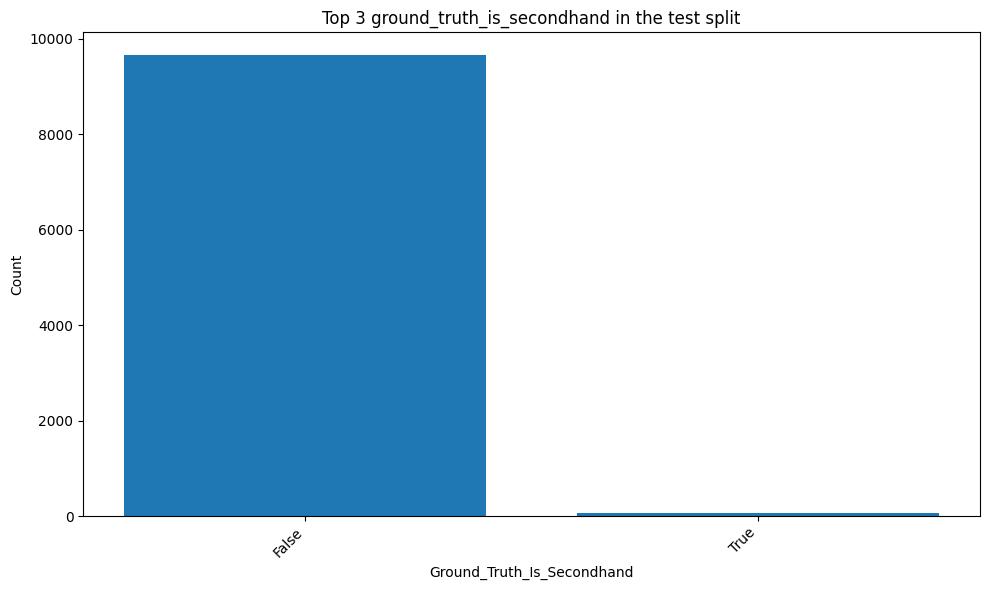

In [10]:
count_and_plot_top_n(dataset, "train", lambda p: p.get('ground_truth_is_secondhand'), field_label='ground_truth_is_secondhand', n=3)
count_and_plot_top_n(dataset, "test", lambda p: p.get('ground_truth_is_secondhand'), field_label='ground_truth_is_secondhand', n=3)

The distribution of the image sizes are:

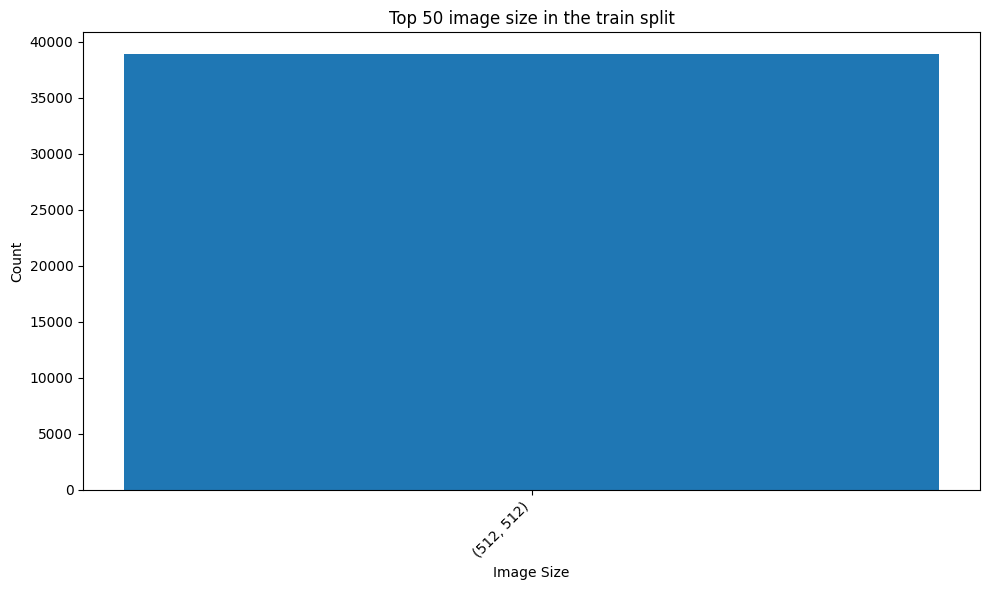

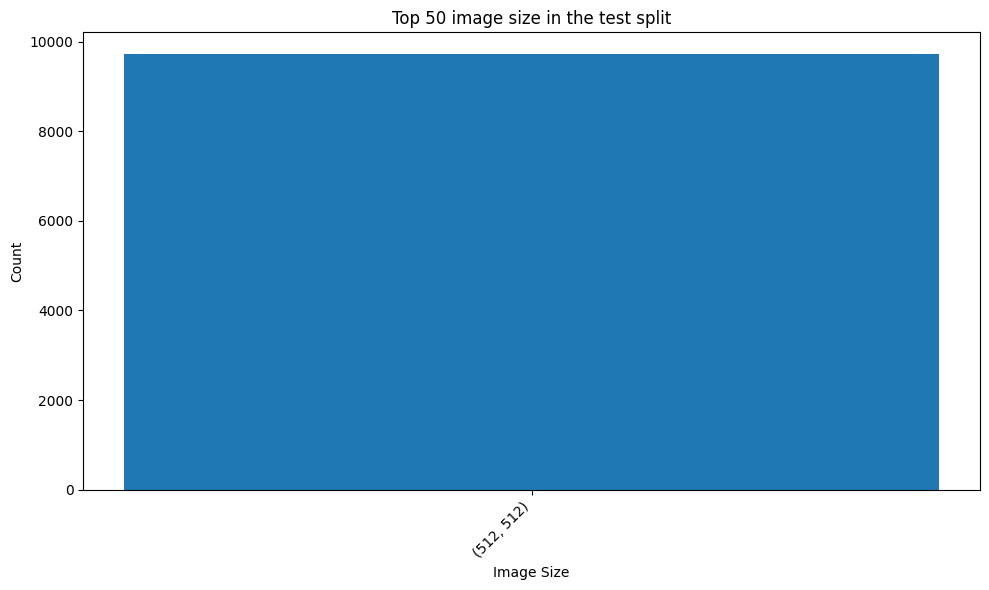

In [11]:
count_and_plot_top_n(dataset, "train", lambda p: (p.get('product_image').width, p.get('product_image').height), field_label='image size', n=50)
count_and_plot_top_n(dataset, "test", lambda p: (p.get('product_image').width, p.get('product_image').height), field_label='image size', n=50)

The distribution of the number of visual tokens is:

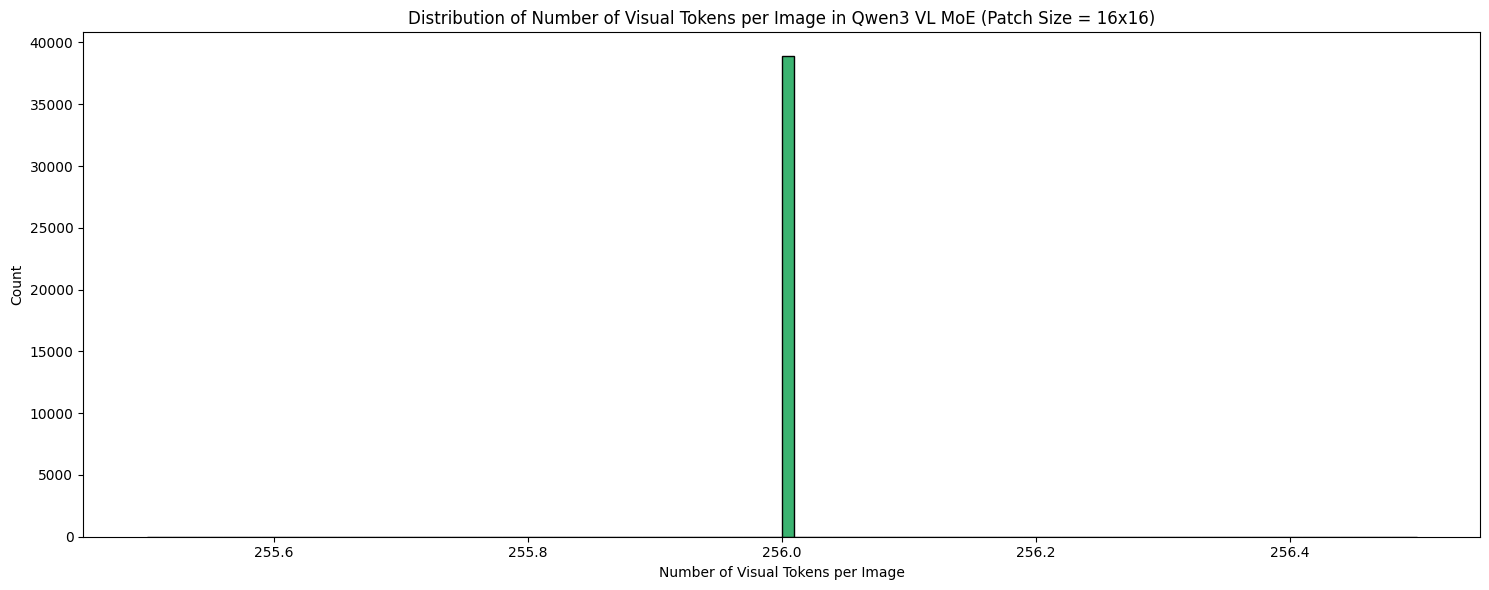

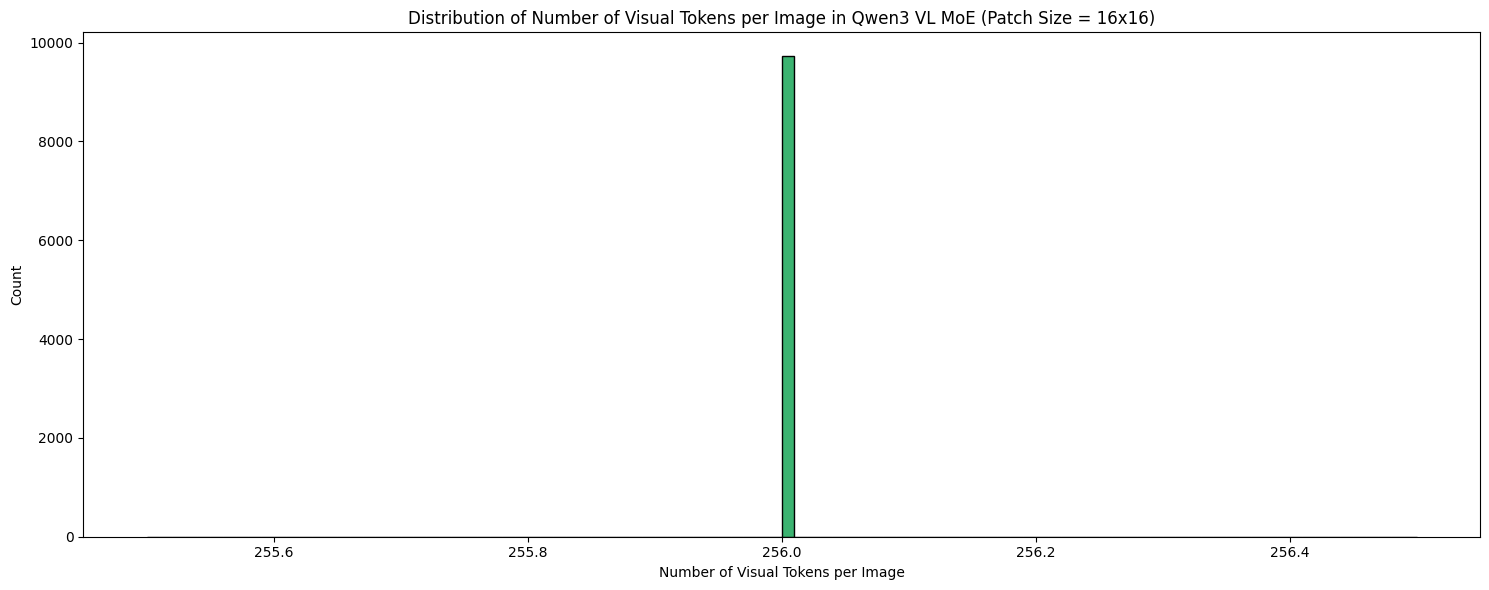

In [13]:
def plot_visual_tokens_distribution(dataset, split):
    patch_size = 16
    spatial_merge_size = 2

    num_visual_tokens = [
        (p['product_image'].width // patch_size // spatial_merge_size) * (p['product_image'].height // patch_size // spatial_merge_size)
        for p in dataset[split]
        if p.get('product_image') is not None
    ]

    plt.figure(figsize=(15,6))
    hist_vals, bin_edges, _ = plt.hist(num_visual_tokens, bins=100, color='mediumseagreen', edgecolor='black')
    plt.title(f"Distribution of Number of Visual Tokens per Image in Qwen3 VL MoE (Patch Size = {patch_size}x{patch_size})")
    plt.xlabel("Number of Visual Tokens per Image")

    tick_step = int((max(num_visual_tokens) - min(num_visual_tokens)) / 20)  # 20 ticks
    if tick_step > 0:
        ticks = np.arange(min(num_visual_tokens), max(num_visual_tokens) + tick_step, tick_step)
        plt.xticks(ticks, rotation=45)

    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_visual_tokens_distribution(dataset, "train")
plot_visual_tokens_distribution(dataset, "test")


The image file formats are:

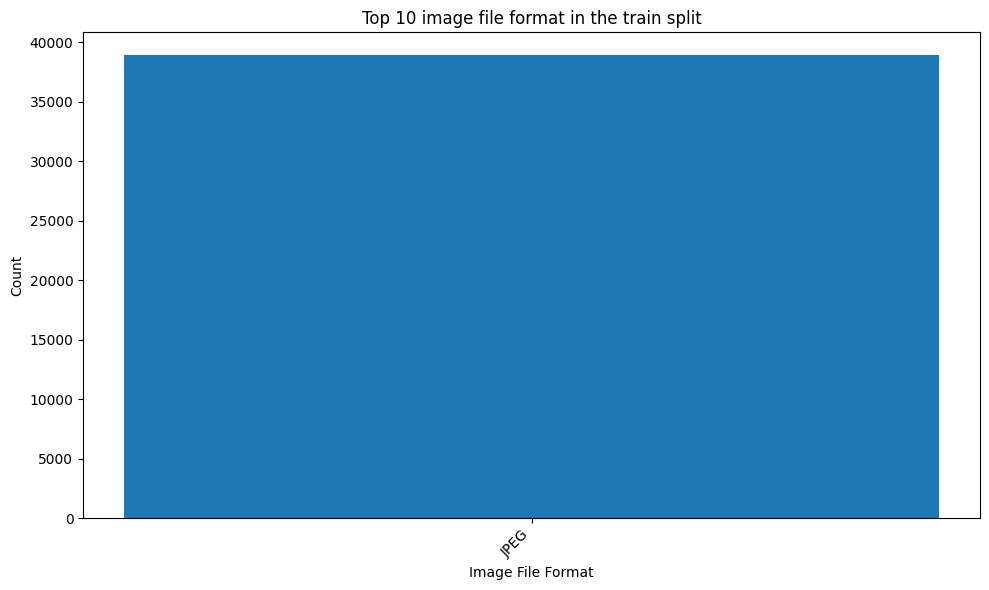

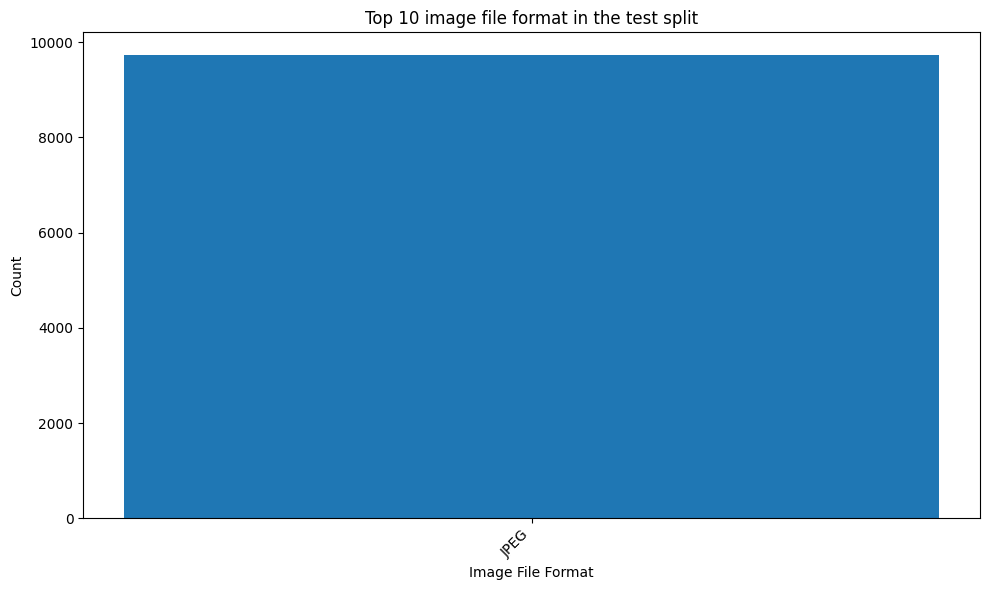

In [15]:
count_and_plot_top_n(dataset, "train", lambda p: p['product_image'].format, field_label='image file format', n=10)
count_and_plot_top_n(dataset, "test", lambda p: p['product_image'].format, field_label='image file format', n=10)

Send the requests to the inference endpoint and gather the responses.

In [ ]:
openai_api_client = OpenAI(api_key="", base_url="http://localhost:8000/v1")
responses = [
    openai_api_client.chat.completions.create(
        model="Qwen/Qwen3-VL-30B-A3B-Instruct",
        messages=ShopifyGlobalCatalogue.formulate_messages(product),
    ) for product in dataset
]
prompt_tokens_counter = Counter(response.usage.prompt_tokens for response in responses)
completion_tokens_counter = Counter(response.usage.completion_tokens for response in responses)
total_tokens_counter = Counter(response.usage.total_tokens for response in responses)    

In [ ]:
import numpy as np

# Convert Counters to lists of token counts (each count per response)
prompt_tokens = []
for token_count, freq in prompt_tokens_counter.items():
    prompt_tokens.extend([token_count] * freq)
completion_tokens = []
for token_count, freq in completion_tokens_counter.items():
    completion_tokens.extend([token_count] * freq)
total_tokens = []
for token_count, freq in total_tokens_counter.items():
    total_tokens.extend([token_count] * freq)

# Define bins in intervals of a specified bin_size, up to max token count (rounded up to next bin_size)
def get_bins(data, bin_size=100):
    max_val = max(data) if len(data) > 0 else bin_size
    bins = np.arange(0, ((max_val // bin_size) + 2) * bin_size, bin_size)
    return bins


fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Histogram for prompt_tokens
axs[0].hist(prompt_tokens, bins=get_bins(prompt_tokens), color='blue', edgecolor='black')
axs[0].set_title("Distribution of Prompt Tokens (100-token bins)")
axs[0].set_xlabel("Prompt Tokens")
axs[0].set_ylabel("Count")

# Histogram for completion_tokens
axs[1].hist(completion_tokens, bins=get_bins(completion_tokens, bin_size=5), color='orange', edgecolor='black')
axs[1].set_title("Distribution of Completion Tokens (100-token bins)")
axs[1].set_xlabel("Completion Tokens")
axs[1].set_ylabel("Count")

# Histogram for total_tokens
axs[2].hist(total_tokens, bins=get_bins(total_tokens), color='green', edgecolor='black')
axs[2].set_title("Distribution of Total Tokens (100-token bins)")
axs[2].set_xlabel("Total Tokens")
axs[2].set_ylabel("Count")

plt.tight_layout()
plt.show()
